In [2]:
import pandas as pd
import numpy as np

from matplotlib import figure, legend, tight_layout
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from shapely import wkt

import re

/var/folders/mz/c8x2p_9j52vfqgt9fpt4175c0000gn/T/ipykernel_3781/1998852095.py:4: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib import figure, legend, tight_layout


In [3]:
block_list = {
              '1' : ['Altstadt', 'Lehel'],
              '2' : ['Ludwigvorstadt', 'Isarvorstadt'], 
              '3' : ['Maxvorstadt'], 
              '4' : ['Schwabing-West'], 
              '5' : ['Aubing', 'Lochhausen', 'Langwied'], 
              '6' : ['Sendling-Westpark'], 
              '7' : ['Sendling'], 
              '8' : ['Schwanthalerhöhe'], 
              '9' : ['Neuhausen', 'Nymphenbrug'], 

              '10' : ['Moosach'], 
              '11' : ['Milbertshofen', 'Am Hart'], 
              '12' : ['Schwabing', 'Freimann'], 
              '13' : ['Bogenhausen'], 
              '14' : ['Berg am Laim'], 
              '15' : ['Trudering', 'Riem'], 
              '16' : ['Ramersdorf', 'Perlach'],
              '17' : ['Obergiesing', 'Fasangarten'], 
              '18' : ['Untergiesing', 'Harlaching'],
              '19' : ['Thalkirchen', 'Obersendling', 'Forstenried', 'Fürstenried', 'Solln'],

              '20' : ['Hadern'], 
              '21' : ['Pasing', 'Obermenzing'], 
              '22' : ['Au', 'Heidhausen'], 
              '23' : ['Allach', 'Untermenzing'], 
              '24' : ['Feldmoching', 'Hasenbergl'], 
              '25' : ['Laim']
}


In [4]:
german_df = pd.read_csv('assets/stadtbezirke.csv', dtype={'name' : str})

In [5]:
import geopandas as gpd
from shapely import wkt


german_df['shape'] = german_df['shape'].apply(wkt.loads)
german_df = gpd.GeoDataFrame(german_df)
german_df = german_df.set_geometry('shape')

In [6]:
df_predictions = pd.read_csv('pred.csv')
df_first =  df_predictions[df_predictions['pred'] == 1]
df_second = df_predictions[df_predictions['pred'] == 2]
df_third =  df_predictions[df_predictions['pred'] == 3]


In [7]:
def plot_results(df_pred, df, colormap, title):
    """
    Plot the results of a prediction on a map.

    Args:
        df_pred (pandas.DataFrame): DataFrame containing the prediction results.
        df (pandas.DataFrame): DataFrame containing the map data.
        colormap (str): Colormap to use for plotting.
    """
    
    counts = dict(df_pred['num'].value_counts())

    for i in range(len(block_list)):
        if i+1 not in counts.keys():
            counts[i+1] = 0

    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()

    df['res'] = df['sb_nummer'].apply(lambda x: counts[int(x)])
    df.plot(column='res', cmap=colormap, ax=ax, legend=True)

    plt.title(title)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    for item in df.values:
        x = item[2]
        y = item[3]
        ax.text(x=x, y=y, s=item[4], ha='center', fontsize=10);


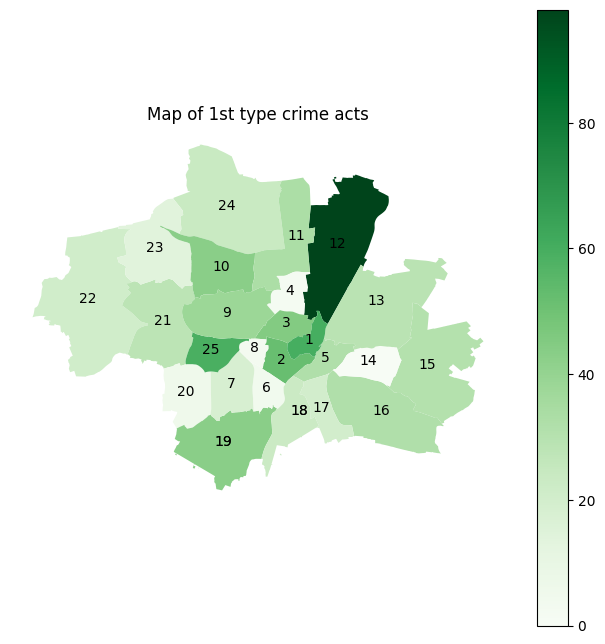

In [8]:
plot_results(df_first, german_df, 'Greens', 'Map of 1st type crime acts')

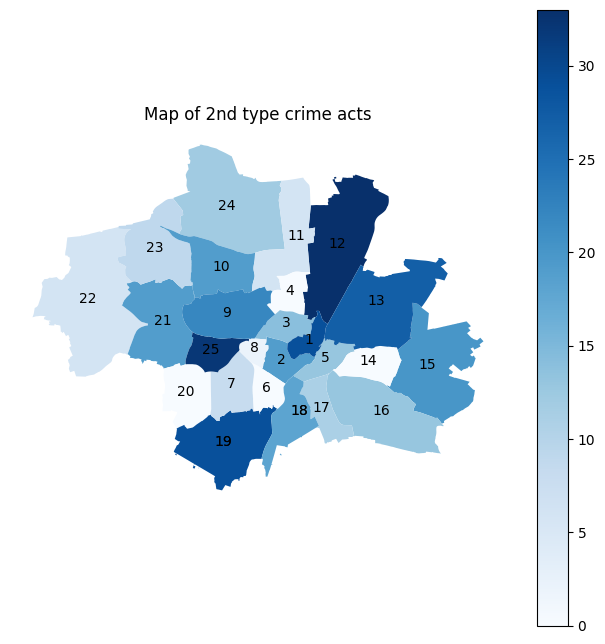

In [9]:
plot_results(df_second, german_df, 'Blues', 'Map of 2nd type crime acts')

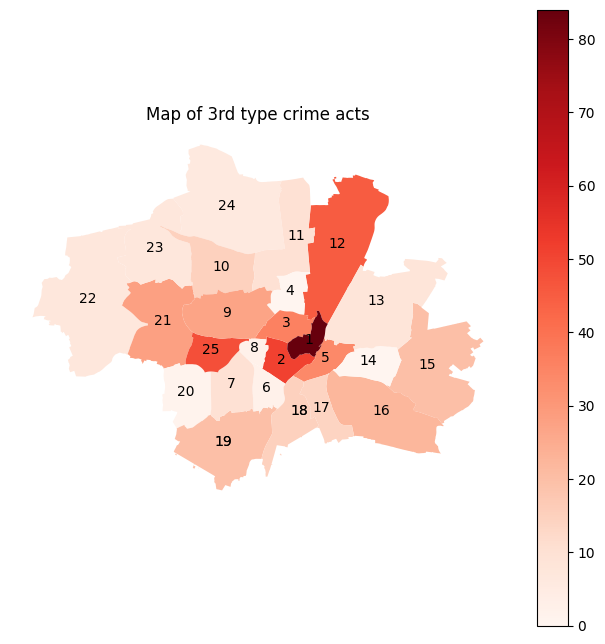

In [10]:
plot_results(df_third, german_df, 'Reds', 'Map of 3rd type crime acts')

In [11]:
# Join the 'num' column values with the corresponding block list values
df_predictions['num'] = df_predictions['num'].apply(lambda x: str(x) + '. ' + ' , '.join(block_list[str(x)]))

# Generate a pivot table with counts of 'new' values for each 'num' and 'pred' combination
pv_table = pd.pivot_table(data=df_predictions, index='num', columns='pred', aggfunc='count').fillna(0)['new'].astype(int)

pv_table['sum'] = pv_table[1] + pv_table[2] + pv_table[3]
pv_table = pv_table.sort_values(by='sum', ascending=False)
pv_table.drop('sum', axis=1, inplace=True)
pv_table


pred,1,2,3
num,,,
"12. Schwabing , Freimann",98,33,45
"1. Altstadt , Lehel",60,29,84
25. Laim,59,32,48
"2. Ludwigvorstadt , Isarvorstadt",52,19,51
3. Maxvorstadt,45,14,36
"19. Thalkirchen , Obersendling , Forstenried , Fürstenried , Solln",43,29,20
"9. Neuhausen , Nymphenbrug",38,22,27
"5. Aubing , Lochhausen , Langwied",32,13,34
10. Moosach,43,19,15


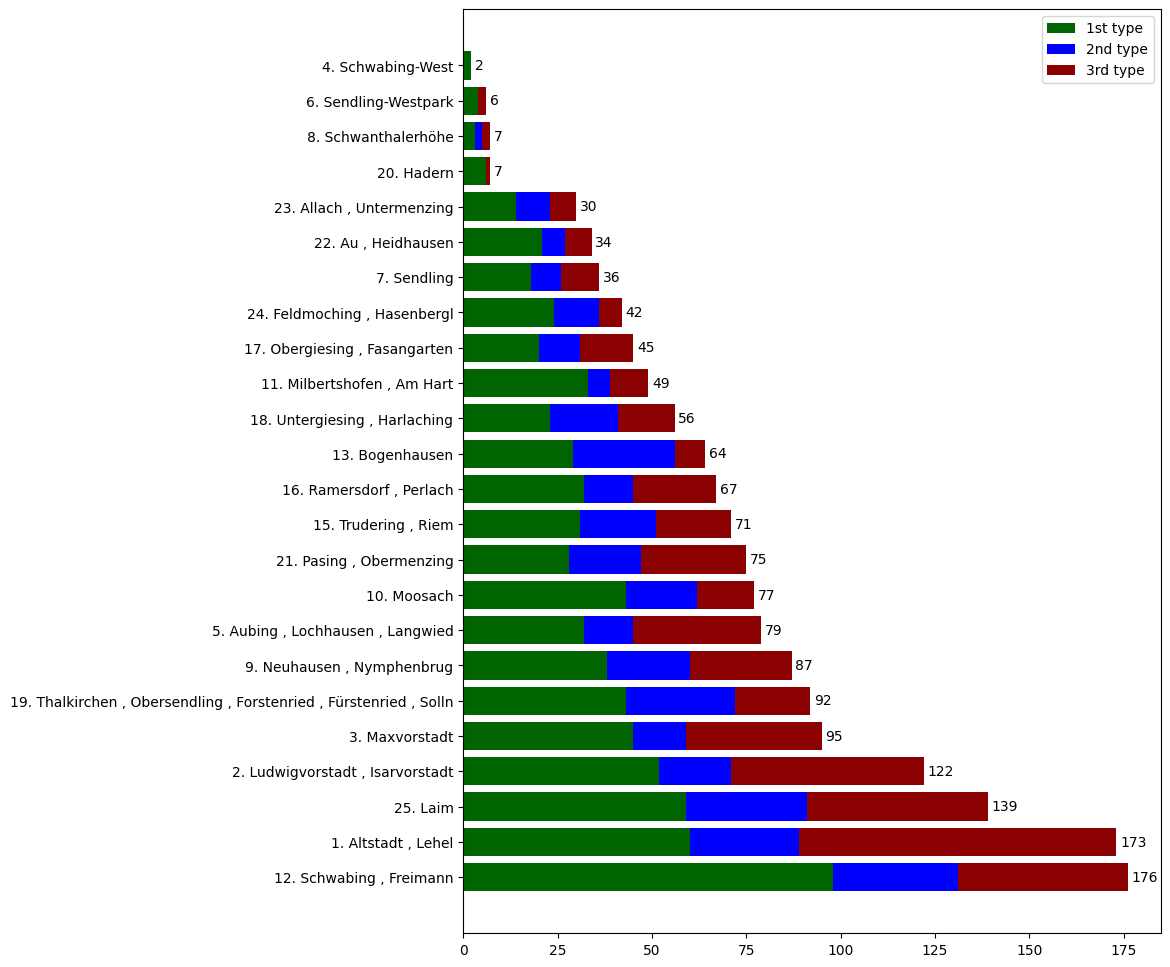

In [21]:
plt.figure(figsize=(9, 12))
plt.barh(y=pv_table.index, width=pv_table[1].tolist(), color='darkgreen')
plt.barh(y=pv_table.index, left=pv_table[1].tolist(), width=pv_table[2].tolist(), color = 'darkblue')
plt.barh(y=pv_table.index, left=list(np.array(pv_table[1].tolist()) +  np.array(pv_table[2].tolist())), 
         width=pv_table[3].tolist(), color = 'darkred')

plt.legend(['1st type', '2nd type', '3rd type'])

sum = pv_table[1] + pv_table[2] + pv_table[3]

for i, v in enumerate(pv_table[3].tolist()):
    plt.text(v + pv_table[1].tolist()[i] + pv_table[2].tolist()[i] + 1, i, sum.tolist()[i], color='black', va='center')


In [13]:
df_predictions

,new,num,pred
0,480. Einbruch in Wohnung – Bogenhausen Zwische...,13. Bogenhausen,2
1,470. Zusammenstoß zwischen Linienbus und Tramb...,13. Bogenhausen,1
2,471. Zusammenstoß zwischen Pkw und Fußgängerin...,25. Laim,1
3,473. Körperverletzungsdelikt - Pasing Am Samst...,"21. Pasing , Obermenzing",3
4,474. Ein Trickdiebstahl - Bogenhausen Am Samst...,13. Bogenhausen,3
...,...,...,...
1626,461. Betriebsunfall; eine Person tödlich verle...,"17. Obergiesing , Fasangarten",1
1627,463. Verkehrsunfall zwischen Pkw und Leichtkra...,"21. Pasing , Obermenzing",1
1628,464. Organisierter Callcenterbetrug; Falsche P...,"12. Schwabing , Freimann",2
1629,465. Öffentlichkeitsfahndung nach Vermisstenfa...,"12. Schwabing , Freimann",3
